In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

DATASET_PATH = '/content/drive/My Drive/BERT_NLP/datasets/'

Mounted at /content/drive


In [57]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 4.2 MB/s 
     |████████████████████████████████| 596 kB 45.5 MB/s 
     |████████████████████████████████| 895 kB 47.8 MB/s 
     |████████████████████████████████| 67 kB 5.4 MB/s 
     |████████████████████████████████| 6.5 MB 25.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [58]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", problem_type="multi_label_classification")

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

In [ ]:
model.summary()

Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_75 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [2]:
import tensorflow as tf
import pandas as pd


In [108]:
# colnames=["LABEL_COLUMN",'tweet_id', 'DATA_COLUMN'] 
tweets_df = pd.read_csv(DATASET_PATH+str('retweet_dataset_sentiment.csv'), ',', header=0)
tweets_df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


,sentiment,id,Tweet
0,negative,1.222258e+18,"It’s Super Bowl week, and Trump is using a pre..."
1,negative,1.236433e+18,Turns out Donald Trump was potentially exposed...
2,positive,1.233925e+18,Had a totally surreal author moment at B&N tod...
3,neutral,1.223632e+18,"Forgive me, but I have to say this: imagine if..."
4,negative,1.222541e+18,The ban imposed on #kunalkamra by 4 airlines i...


In [109]:
d1 = tweets_df[((tweets_df.sentiment == "positive") )]
d2 = d1.append(tweets_df[((tweets_df.sentiment == "negative") )])

tweets_df = d2
tweets_df = tweets_df[(tweets_df.Tweet != "Not Available")]
# tweets_df.drop(labels=['id'], inplace=True, axis=1)
tweets_df.rename(columns={'Tweet':'DATA_COLUMN', 'sentiment':'LABEL_COLUMN'}, inplace=True)
tweets_df.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,LABEL_COLUMN,id,DATA_COLUMN
2,positive,1.233925e+18,Had a totally surreal author moment at B&N tod...
5,positive,1.236140e+18,The 87-year old patient stayed in Wu Han hospi...
14,positive,1.232519e+18,I feel like the most powerful witch to have ev...
15,positive,1.238385e+18,The secret’s out.. I’m swapping one ballroom f...
17,positive,1.222715e+18,No more #SmokeAndMirrors. The president has c...


In [110]:
# @title Remove Links and Hashtags and Emojis

import re
import string

def removeLinks(text):
    link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links         = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')    
    return text

def cleanAtTheRateAndHashtags(text):
    junk = ['\u2066','@', '#', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0']
    words = text.split()
    res =[]
    for word in words:
      # print(word[0])
      if word[0] not in junk:
        res.append(word)
    return " ".join(res)

def deEmojify(text):
    "function to remove emojis from text"
    regrex_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return regrex_pattern.sub(r'',text)

def cleanseText(text):
    text = removeLinks(text)
    # print(text)
    txt = cleanAtTheRateAndHashtags(text)
    # re.sub(r'[^\x00-\x7F]+','', text)
    # print(txt)
    txt = deEmojify(txt)
    return txt.encode('ascii', 'ignore').decode('ascii')


# clean df
tweets_df['DATA_COLUMN'] = tweets_df['DATA_COLUMN'].apply(lambda tweet: cleanseText(tweet))

tweets_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,LABEL_COLUMN,id,DATA_COLUMN
2,positive,1.233925e+18,Had a totally surreal author moment at B&N tod...
5,positive,1.236140e+18,The old patient stayed in Wu Han hospital for ...
14,positive,1.232519e+18,I feel like the most powerful witch to have ev...
15,positive,1.238385e+18,The secrets out.. Im swapping one ballroom for...
17,positive,1.222715e+18,No more The president has confessed to everyth...


In [111]:
tweets_df.rename(columns={'LABEL_COLUMN' : 'True Sentiment', 'id' : 'Tweet ID', 'DATA_COLUMN' : 'Tweet'}, inplace=True)
tweets_df.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,True Sentiment,Tweet ID,Tweet
2,positive,1.233925e+18,Had a totally surreal author moment at B&N tod...
5,positive,1.236140e+18,The old patient stayed in Wu Han hospital for ...
14,positive,1.232519e+18,I feel like the most powerful witch to have ev...
15,positive,1.238385e+18,The secrets out.. Im swapping one ballroom for...
17,positive,1.222715e+18,No more The president has confessed to everyth...


In [112]:
from google.colab import files


tweets_df.to_csv('double_pol_retweet.csv', index=False)
files.download('double_pol_retweet.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [48]:
LABELS = {'negative':0, 'positive':1}
# print(LABELS['neutral'])
counter = -1
def convertLabels(sentiment):
  # print(tweet)
  # counter += 1
  return LABELS[sentiment]

tweets_df['LABEL_COLUMN'] = tweets_df['LABEL_COLUMN'].apply(lambda label: convertLabels(label))
tweets_df.head()

,LABEL_COLUMN,DATA_COLUMN
2,1,Had a totally surreal author moment at B&N tod...
5,1,The 87-year old patient stayed in Wu Han hospi...
14,1,I feel like the most powerful witch to have ev...
15,1,The secret’s out.. I’m swapping one ballroom f...
17,1,No more #SmokeAndMirrors. The president has c...


In [49]:
selected_columns = tweets_df[["DATA_COLUMN","LABEL_COLUMN"]]
tweets_new_df = selected_columns.copy()

In [ ]:
# selected_columns = test_df[["DATA_COLUMN","LABEL_COLUMN"]]
# test_df_new = selected_columns.copy()

In [50]:
# tweets_new_df = tweets_new_df[tweets_new_df.line_race != 'Not Available']

tweets_new_df = tweets_new_df[(tweets_new_df.DATA_COLUMN != "Not Available")]

tweets_new_df.head()

,DATA_COLUMN,LABEL_COLUMN
2,Had a totally surreal author moment at B&N tod...,1
5,The 87-year old patient stayed in Wu Han hospi...,1
14,I feel like the most powerful witch to have ev...,1
15,The secret’s out.. I’m swapping one ballroom f...,1
17,No more #SmokeAndMirrors. The president has c...,1


In [51]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [52]:
tweets_new_df = shuffle(shuffle(tweets_new_df))

In [66]:
# train_full, test = train_test_split(tweets_data, test_size=0.3)
remainingAfterValSplit, val = train_test_split(tweets_new_df, test_size=0.15)
train, test = train_test_split(remainingAfterValSplit, test_size=0.15)
# test = test_df_new
train.shape

(645, 2)

In [67]:

train.LABEL_COLUMN.value_counts()

0    355
1    290
Name: LABEL_COLUMN, dtype: int64

In [68]:
# @title Prepare Examples Funcs

InputExample(guid=None,
             text_a = "Hello, world",
             text_b = None,
             label = 1)

def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN): 
  train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

  validation_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)
  
  return train_InputExamples, validation_InputExamples

  train_InputExamples, validation_InputExamples = convert_data_to_examples(train, 
                                                                           test, 
                                                                           'DATA_COLUMN', 
                                                                           'LABEL_COLUMN')
  
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )


DATA_COLUMN = 'DATA_COLUMN'
LABEL_COLUMN = 'LABEL_COLUMN'

In [69]:
train_InputExamples, validation_InputExamples = convert_data_to_examples(train, val, DATA_COLUMN, LABEL_COLUMN)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [71]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

history = model.fit(train_data, epochs=3, validation_data=validation_data)

Epoch 1/3
42/42 [==============================] - 119s 2s/step - loss: 0.1161 - accuracy: 0.9690 - val_loss: 0.0463 - val_accuracy: 0.9925
Epoch 2/3
42/42 [==============================] - 67s 2s/step - loss: 0.0277 - accuracy: 0.9938 - val_loss: 0.0404 - val_accuracy: 0.9925
Epoch 3/3
42/42 [==============================] - 67s 2s/step - loss: 0.0115 - accuracy: 0.9969 - val_loss: 0.0435 - val_accuracy: 0.9925


In [72]:
import matplotlib.pyplot as plt

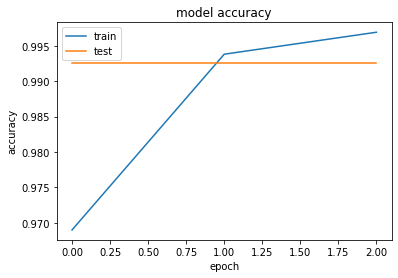

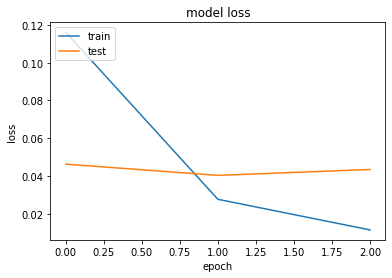

In [73]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [76]:
test_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)
test_data = convert_examples_to_tf_dataset(list(test_InputExamples), tokenizer)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
model.evaluate(test_data)

In [ ]:
while True:
  pass

In [79]:
tl = list(test.DATA_COLUMN)

In [86]:
# t = tweets_new_df.DATA_COLUMN[0]
preds_list = []

In [90]:
pred_sentences = tl

In [91]:
tf_batch = tokenizer(pred_sentences, max_length=128, padding=True, truncation=True, return_tensors='tf')
tf_outputs = model(tf_batch)
tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
labels = ['Negative', 'Positive']
label = tf.argmax(tf_predictions, axis=1)
label = label.numpy()

test['Predicted_Label'] = label

In [92]:
test.head()

,DATA_COLUMN,LABEL_COLUMN,Predicted_Label
996,This was not and will not be a ‘foreign flag’ ...,1,0
1423,It’s been a very long week. So here’s a video...,1,0
805,We call on government communication agencies t...,1,1
479,The best news so far this year! We salute all...,1,1
109,A doctor in Victoria has been diagnosed with c...,0,0


In [84]:
preds_list[0:10]

[['This was not and will not be a ‘foreign flag’ in the UK.  If not for the European Union, it is also the flag of the Council of Europe which the UK is co-founder and will stay member of.  European cooperation means peace and friendship. This flag symbolises exactly that. https://t.co/sumQmwVvU6',
  'Negative'],
 ['It’s been a very long week.  So here’s a video of how Iranian healthcare workers are dealing with the stress of fighting coronavirus.  Take some breaks y’all. Being on and anxious 24/7 isn’t good for us ❤️💃🏼   https://t.co/w1VpdsRPov',
  'Negative'],
 ['We call on government communication agencies to prioritize public health interests in the light of a possible corona virus outbreak. #BeNice https://t.co/PKi0zxBtlG',
  'Positive'],
 ['The best news so far this year! We  salute all the health workers who are committed to saving lives every single day. Thanks to @MinofHealthUG for the effort put in to accomplish this and more. https://t.co/w2biC9JPkl',
  'Positive'],
 ['A doc

In [94]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(test['LABEL_COLUMN'], test['Predicted_Label'])
print(f'Accracy of the model is {acc:1.2f}')

Accracy of the model is 0.96


# Testing Sec Under Construction :)

In [ ]:
colnames=['tweet_id', "sentiment", "DATA_COLUMN"] 
test_df = pd.read_csv(DATASET_PATH+str('2points_test.tsv'), '\t', header=None, names=colnames)
test_df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


,tweet_id,sentiment,DATA_COLUMN
0,6.376667e+17,negative,Sony rewards app is like a lot of 19 y.o femal...
1,6.377084e+17,positive,Finally I get my ps4 back I sent it to Sony ca...
2,6.378075e+17,negative,Not Available
3,6.381419e+17,positive,Not Available
4,6.381593e+17,positive,Not Available


In [ ]:

test_df = test_df[(test_df.DATA_COLUMN != "Not Available")]

test_df.head()

In [ ]:
selected_columns = test_df[["DATA_COLUMN","sentiment"]]

test_df_new = selected_columns.copy()
test_df_new.head()

In [ ]:
LABELS = {'negative':0, 'positive':1}
# print(LABELS['neutral'])
def convertLabels(sentiment):
  return LABELS[sentiment]

test_df_new['LABEL_COLUMN'] = test_df_new['sentiment'].apply(lambda label: convertLabels(label))
test_df_new.head()

In [ ]:
test_df_new.drop(labels=['sentiment'], inplace=True, axis=1)
test_df_new.head()


In [ ]:
test_InputExamples = test_df_new.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)
test = convert_examples_to_tf_dataset(list(test_InputExamples), tokenizer)
# test = test.shuffle(100).batch(32).repeat(2)

In [ ]:
print(train_data)

In [ ]:
model.evaluate(test)